In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az


sns.set_style("whitegrid")

In [2]:
train_clf = pd.read_csv('classify/train_clf.csv')

/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

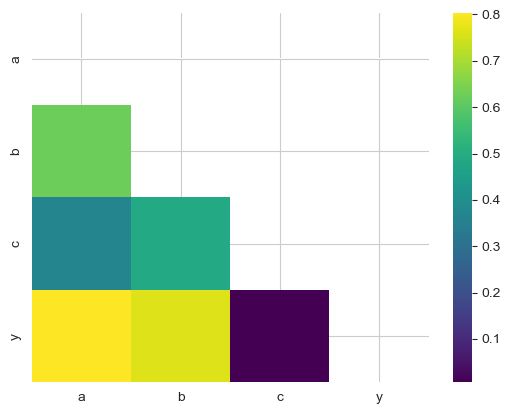

In [3]:
corr = train_clf.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

### Переменная c вообще не коррелирует с таргетом - дропаем

In [4]:
columns = ['a', 'b']
X_train = train_clf[columns].values
y_train = train_clf['y'].values

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = train_clf[columns]
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

with pm.Model() as model_3:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.StudentT('β', mu=1, sigma=2, nu=50, shape=len(columns)) # nu =50-70
    μ = α + pm.math.dot( X_transform,β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X_transform[:, 0])

    yl = pm.Bernoulli('yl', p=θ, observed=y_train)

    trace_3 = pm.sample(3000, chains = 4, cores = 16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


In [6]:
varnames = ['α','β','bd']
az.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.327,0.522,-1.303,0.661,0.005,0.004,10757.0,7887.0,1.0
β[0],-3.656,0.876,-5.273,-2.072,0.010,0.007,7947.0,8028.0,1.0
β[1],-3.195,0.810,-4.716,-1.711,0.009,0.007,8190.0,7770.0,1.0
θ[0],0.009,0.011,0.000,0.027,0.000,0.000,6695.0,6565.0,1.0
θ[1],0.000,0.000,0.000,0.001,0.000,0.000,6536.0,6467.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],0.912,0.311,0.391,1.491,0.003,0.002,15204.0,10017.0,1.0
bd[96],-0.582,0.246,-1.039,-0.139,0.002,0.002,13831.0,9353.0,1.0
bd[97],-0.922,0.327,-1.546,-0.362,0.003,0.002,14581.0,8959.0,1.0
bd[98],1.386,0.436,0.666,2.197,0.004,0.003,16118.0,10093.0,1.0


In [7]:
df = az.summary(trace_3, var_names=['α','β'] )
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.327,0.522,-1.303,0.661,0.005,0.004,10757.0,7887.0,1.0
β[0],-3.656,0.876,-5.273,-2.072,0.010,0.007,7947.0,8028.0,1.0
β[1],-3.195,0.810,-4.716,-1.711,0.009,0.007,8190.0,7770.0,1.0


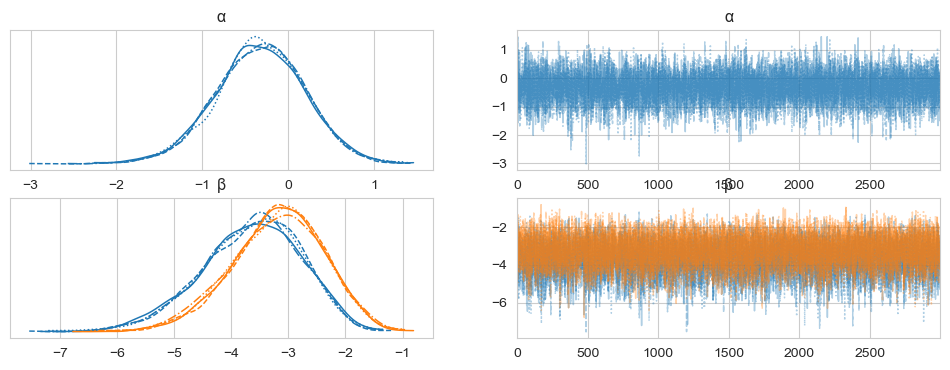

In [8]:
az.plot_trace(trace_3, var_names = ['α','β'],compact=True);

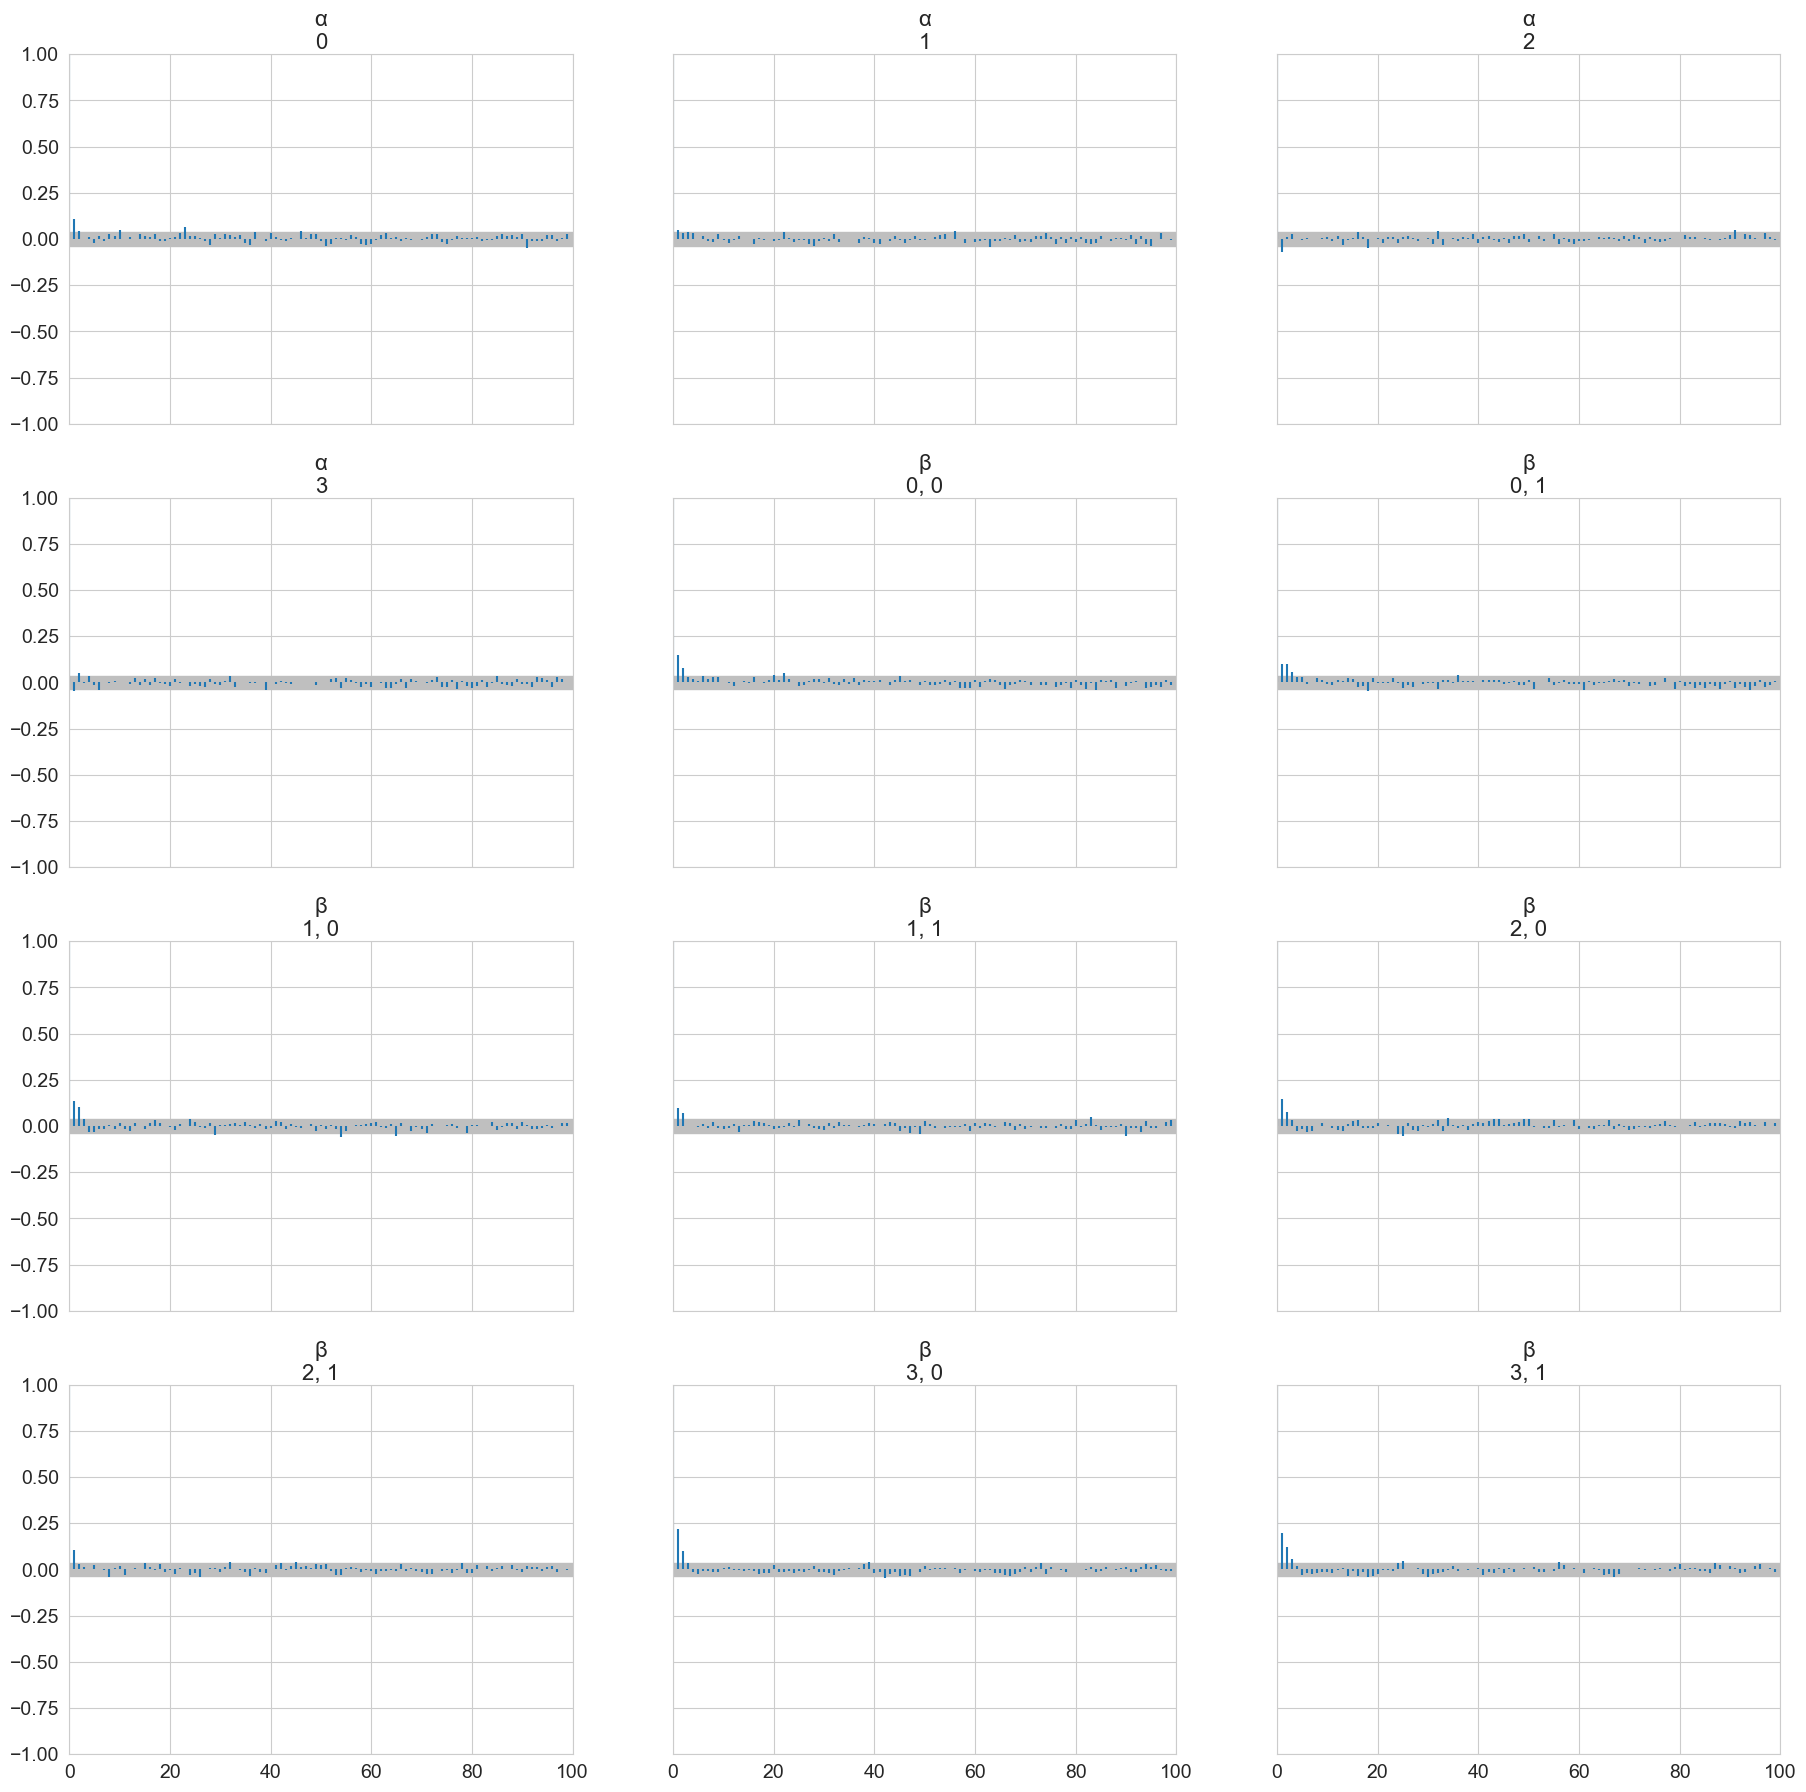

In [9]:
az.plot_autocorr(trace_3, ['α', 'β']);

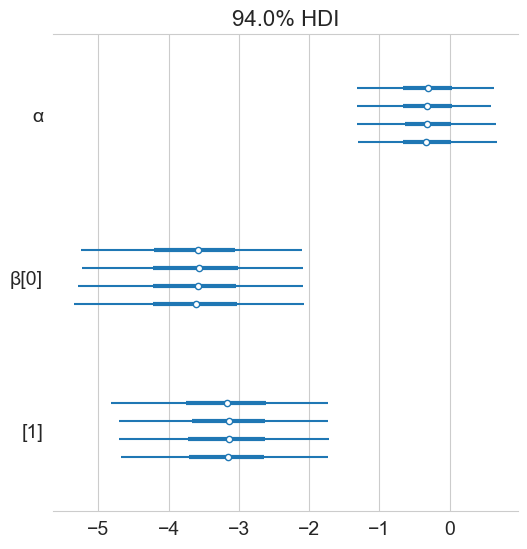

In [10]:
varnames = ['α', 'β']
az.plot_forest(trace_3, var_names=varnames);

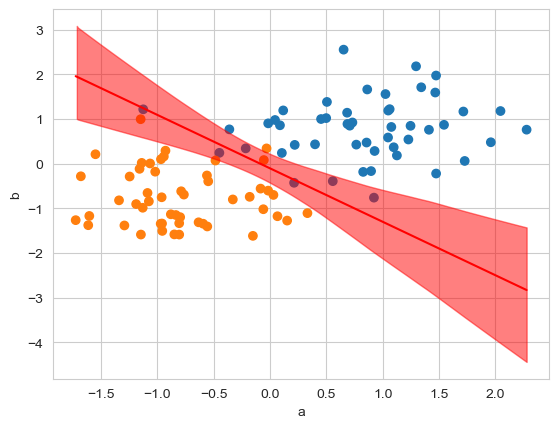

In [11]:
y_train_int8_array = y_train.astype(np.int8)
idx = np.argsort(X_transform[:,0])
bd = trace_3.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(X_transform[:,0], X_transform[:,1], c=[f'C{i}' for i in y_train_int8_array])

plt.plot(X_transform[:,0][idx], bd, color='r');
az.plot_hdi(X_transform[:,0], trace_3.posterior['bd'], color='r')

plt.xlabel(columns[0]);
plt.ylabel(columns[1]);

### Предсказываем на тестовых данных

In [12]:
# Load the test data
test_df = pd.read_csv('classify/test_clf.csv')

# Extract the relevant columns
X_test = test_df[columns]
X_test_transformed = scaler.transform(X_test)


In [13]:
alpha = trace_3.posterior['α'].mean(("chain", "draw")).values
betta = trace_3.posterior["β"].mean(("chain", "draw")).values

z = alpha + np.dot(X_test_transformed, betta)
predicted_probabilities = 1 / (1 + np.exp(-z))

threshold = 0.5  # You can adjust the threshold as needed
predicted_labels = (predicted_probabilities > threshold).astype(int)


In [14]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, predicted_labels)

0.96

### Задача 2

In [26]:
train_clf = pd.read_csv('classify/train_clf.csv')
columns = ['a', 'b']
X_train = train_clf[columns].values
y_train = train_clf['y'].values

In [27]:
X = train_clf[columns]
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

In [28]:
mask_0 = y_train==0
mask_1 = y_train==1

In [29]:
x_0 = X_transform

with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    
    one = pm.Normal('one', mu=μ[0], sigma=σ[0], observed=x_0[mask_0]) 
    two = pm.Normal('two', mu=μ[1], sigma=σ[1], observed=x_0[mask_1]) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(500, chains = 2, cores = 16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 16 jobs)
NUTS: [μ, σ]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0.5, 0, 'sepal_length')

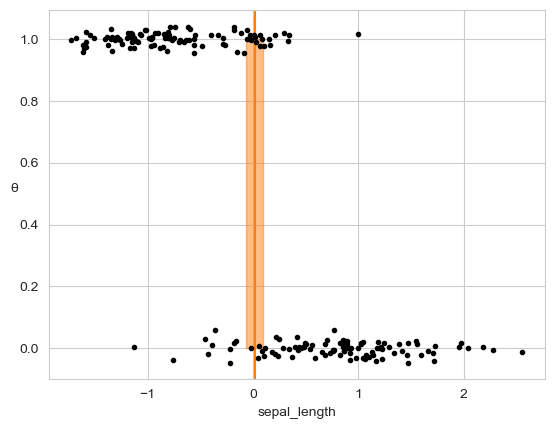

In [30]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_train, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

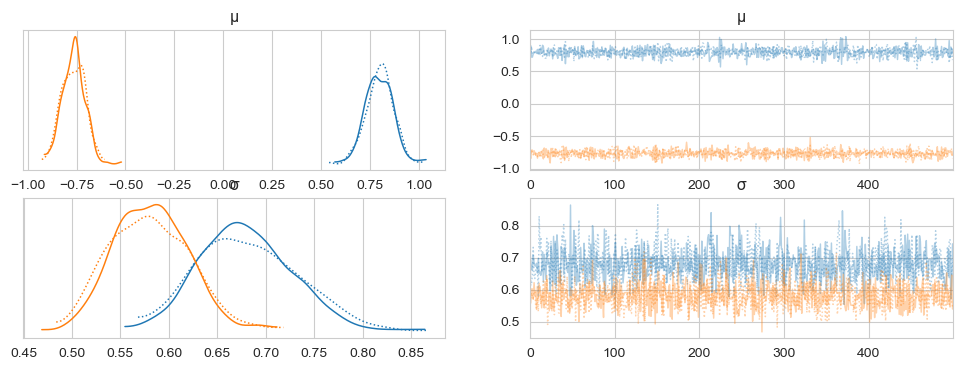

In [31]:
az.plot_trace(trace_lda, var_names = ['μ','σ'],compact=True);

In [32]:
# Load the test data
test_df = pd.read_csv('classify/test_clf.csv')

# Extract the relevant columns
X_test = test_df[columns]

X_test_transformed = scaler.transform(X_test)

predicted_labels = [1 if i < posterior_lda['bd'].mean() else 0 for i in X_test_transformed.sum(axis=1)]

Text(0.5, 0, 'sepal_length')

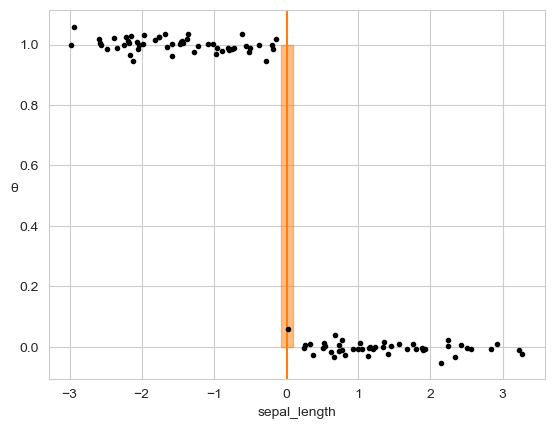

In [33]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)
plt.plot(X_test_transformed.sum(axis=1), np.random.normal(predicted_labels, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

In [34]:
y_pred_test = predicted_labels

In [35]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred_test)

0.96